In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/conflict-clusters.csv')

In [3]:
df.head()

,event_date,year,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,fatalities,timestamp,MA/CU,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters
0,2017-01-01,2017,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Egypt),unknown,3,unknown,unknown,0,30,Northern Africa,Egypt,Cairo,Al Maadi,unknown,Cairo-Al Maadi,29.9667,31.2500,1,0,1578503454,MA,564,56,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,0
1,2017-01-01,2017,Battles,Armed clash,Military Forces of Iraq (2014-2018) Popular Mo...,unknown,1,Islamic State (Iraq),unknown,2,12,Middle East,Iraq,Anbar,Anah,unknown,Aradi as Sakrah,34.1915,42.0313,3,6,1567462133,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1
2,2017-01-01,2017,Explosions/Remote violence,Air/drone strike,Military Forces of Iraq (2014-2018),unknown,1,Islamic State (Iraq),unknown,2,12,Middle East,Iraq,Ninewa,Mosul,unknown,Mosul,36.3350,43.1189,1,20,1572403769,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1
3,2017-01-01,2017,Explosions/Remote violence,Remote explosive/landmine/IED,Islamic State (Iraq),unknown,2,Civilians (Iraq),unknown,7,27,Middle East,Iraq,Najaf,Najaf,unknown,Najaf,32.0259,44.3462,2,6,1572403770,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1
4,2017-01-01,2017,Battles,Armed clash,Islamic State (Iraq),unknown,2,Police Forces of Iraq (2014-2018),unknown,1,12,Middle East,Iraq,Najaf,Manathera,unknown,Al Mishkhab,31.8044,44.4893,1,0,1572403770,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1


In [4]:
data = df.loc[df['country'] == 'Saudi Arabia', :]

In [5]:
data.head()

,event_date,year,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,fatalities,timestamp,MA/CU,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters
12,2017-01-01,2017,Battles,Armed clash,Military Forces of Yemen (2016-) Supreme Polit...,unknown,8,Military Forces of Saudi Arabia (2015-),unknown,1,18,Middle East,Saudi Arabia,Najran,Najran,unknown,Al Khadra,17.4046,44.0200,1,10,1572403796,MA,739,56,1,0.0,3.7507,5.89,0.1,0.26,0.36,0.0,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2
13,2017-01-01,2017,Battles,Armed clash,Military Forces of Yemen (2016-) Supreme Polit...,unknown,8,Military Forces of Saudi Arabia (2015-),unknown,1,18,Middle East,Saudi Arabia,Jizan,Jazan,unknown,Jizan,16.8892,42.5511,3,1,1561471426,MA,739,56,1,0.0,3.7507,5.89,0.1,0.26,0.36,0.0,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2
180,2017-01-03,2017,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Yemen (2016-) Supreme Polit...,unknown,8,Military Forces of Saudi Arabia (2015-),unknown,1,18,Middle East,Saudi Arabia,Jizan,Jazan,unknown,At Tuwal,16.5294,42.9676,1,10,1572403796,MA,782,59,1,0.0,3.7507,5.89,0.1,0.26,0.36,0.0,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2
181,2017-01-03,2017,Battles,Armed clash,Military Forces of Yemen (2016-) Supreme Polit...,unknown,8,Military Forces of Saudi Arabia (2015-),unknown,1,18,Middle East,Saudi Arabia,Asir,Zahran al Janub,unknown,Aqabat al Alb,17.5667,43.4000,1,10,1572403795,MA,782,59,1,0.0,3.7507,5.89,0.1,0.26,0.36,0.0,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2
182,2017-01-03,2017,Battles,Armed clash,Military Forces of Yemen (2016-) Supreme Polit...,unknown,8,Military Forces of Saudi Arabia (2015-),unknown,1,18,Middle East,Saudi Arabia,Jizan,Al Harth,unknown,Ash Shabakah,16.7825,43.2297,1,0,1572403793,MA,782,59,1,0.0,3.7507,5.89,0.1,0.26,0.36,0.0,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2


In [6]:
data.shape

(2881, 58)

In [7]:
data.drop(columns=['year', 
                   'sub_event_type',
                   'actor1',
                   'assoc_actor_1',
                   'inter1',
                   'actor2',
                   'assoc_actor_2',
                   'inter2',
                   'interaction',
                   'region',
                   'admin2',
                   'admin3',
                   'location',
                   'timestamp',
                   'country',
                   'MA/CU'], inplace=True)

In [8]:
df = (pd.to_datetime(data['event_date']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count'))

In [9]:
df.head()

,date,count
0,2018-01-19,15
1,2018-02-11,14
2,2017-12-18,14
3,2018-03-12,13
4,2017-04-03,13


In [10]:
data['event_date'] = pd.to_datetime(data['event_date'])

In [11]:
data = pd.merge(data, df, left_on='event_date', right_on='date', how='outer')

In [12]:
data.head()

,event_date,event_type,admin1,latitude,longitude,geo_precision,fatalities,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters,date,count
0,2017-01-01,Battles,Najran,17.4046,44.0200,1,10,739,56,1,0.0,3.7507,5.89,0.1,0.26,0.36,0.0,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2,2017-01-01,2
1,2017-01-01,Battles,Jizan,16.8892,42.5511,3,1,739,56,1,0.0,3.7507,5.89,0.1,0.26,0.36,0.0,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2,2017-01-01,2
2,2017-01-03,Explosions/Remote violence,Jizan,16.5294,42.9676,1,10,782,59,1,0.0,3.7507,5.89,0.1,0.26,0.36,0.0,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2,2017-01-03,5
3,2017-01-03,Battles,Asir,17.5667,43.4000,1,10,782,59,1,0.0,3.7507,5.89,0.1,0.26,0.36,0.0,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2,2017-01-03,5
4,2017-01-03,Battles,Jizan,16.7825,43.2297,1,0,782,59,1,0.0,3.7507,5.89,0.1,0.26,0.36,0.0,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2,2017-01-03,5


In [13]:
data.set_index('event_date', inplace=True)

In [14]:
data.drop(columns='date', inplace=True)

In [15]:
pd.get_dummies(data=data, 
               columns=['event_type',
                        'admin1'])

,latitude,longitude,geo_precision,fatalities,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters,count,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Violence against civilians,admin1_Al Madinah,admin1_Al-Qassim,admin1_Ar Riyad,admin1_Ash Sharqiyah,admin1_Asir,admin1_Jizan,admin1_Makkah,admin1_Najran
event_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,17.4046,44.0200,1,10,739,56,1,0.0,3.7507,5.89,0.10,0.26,0.36,0.000,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2,2,1,0,0,0,0,0,0,0,0,0,0,0,1
2017-01-01,16.8892,42.5511,3,1,739,56,1,0.0,3.7507,5.89,0.10,0.26,0.36,0.000,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2,2,1,0,0,0,0,0,0,0,0,0,1,0,0
2017-01-03,16.5294,42.9676,1,10,782,59,1,0.0,3.7507,5.89,0.10,0.26,0.36,0.000,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2,5,0,1,0,0,0,0,0,0,0,0,1,0,0
2017-01-03,17.5667,43.4000,1,10,782,59,1,0.0,3.7507,5.89,0.10,0.26,0.36,0.000,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2,5,1,0,0,0,0,0,0,0,0,1,0,0,0
2017-01-03,16.7825,43.2297,1,0,782,59,1,0.0,3.7507,5.89,0.10,0.26,0.36,0.000,-1.68,-0.58,49,7,7,2,3,4,121.48,62,46,74,69,74.87,71.2,6.3,8.0,3.8,9.1,4.7,13.92,56.26,83.62,15.0,2,5,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,17.5760,43.3246,1,10,412,54,12,0.0,3.7509,5.93,0.12,0.29,0.36,-0.025,-1.66,-0.55,53,7,7,2,3,4,122.03,55,50,72,63,74.94,70.4,6.0,8.4,3.2,9.3,4.4,14.63,56.81,83.73,15.5,2,1,1,0,0,0,0,0,0,0,0,1,0,0,0
2019-12-24,17.5204,43.5667,1,0,418,54,12,0.0,3.7509,5.93,0.12,0.29,0.36,-0.025,-1.66,-0.55,53,7,7,2,3,4,122.03,55,50,72,63,74.94,70.4,6.0,8.4,3.2,9.3,4.4,14.63,56.81,83.73,15.5,2,1,0,1,0,0,0,0,0,0,0,1,0,0,0
2019-12-25,16.8333,43.2167,1,0,408,57,12,0.0,3.7509,5.93,0.12,0.29,0.36,-0.025,-1.66,-0.55,53,7,7,2,3,4,122.03,55,50,72,63,74.94,70.4,6.0,8.4,3.2,9.3,4.4,14.63,56.81,83.73,15.5,2,1,0,1,0,0,0,0,0,0,0,0,1,0,0


In [16]:
data.drop(columns=['event_type', 'admin1'], inplace=True)

In [17]:
y = data['count']
X = data.drop(columns=['count'])


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [19]:
minmax = MinMaxScaler()

In [20]:
X_train = minmax.fit_transform(X_train)
X_test = minmax.fit_transform(X_test)

In [21]:
X_train.shape

(2160, 39)

In [55]:
train = TimeseriesGenerator(X_train, y_train, length=3, batch_size=64)
test = TimeseriesGenerator(X_test, y_test, length=3, batch_size=64)

In [23]:
batch_x, batch_y = train[0]

In [24]:
batch_x.shape

(64, 1, 39)

In [57]:
# The LSTM design
model = Sequential()
# First LSTM layer with Dropout 
model.add(LSTM(32, activation='relu', kernel_regularizer=regularizers.l1(1e-5),return_sequences=True, input_shape=(3, 39)))
model.add(Dropout(0.7))
# Second LSTM layer
model.add(LSTM(units=32, activation='relu', kernel_regularizer=regularizers.l1(1e-5),return_sequences=True))
model.add(Dropout(0.7))
# Third LSTM layer
model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(Dropout(0.7))
# The output layer

model.add(Flatten())
model.add(Dense(1))

# Compiling the RNN
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 3, 32)             9216      
_________________________________________________________________
dropout_31 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 3, 32)             8320      
_________________________________________________________________
dropout_32 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 3, 32)             8320      
_________________________________________________________________
dropout_33 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 96)              

In [58]:
# Fitting to the training set
hist = model.fit_generator(train, validation_data=(test), epochs=15)

Epoch 1/15
34/34 [==============================] - 2s 67ms/step - loss: 95.3036 - val_loss: 67.1115
Epoch 2/15
34/34 [==============================] - 0s 6ms/step - loss: 66.5680 - val_loss: 22.6587
Epoch 3/15
34/34 [==============================] - 0s 7ms/step - loss: 61.8258 - val_loss: 35.8135
Epoch 4/15
34/34 [==============================] - 0s 7ms/step - loss: 60.3390 - val_loss: 51.0964
Epoch 5/15
34/34 [==============================] - 0s 7ms/step - loss: 58.7757 - val_loss: 75.1395
Epoch 6/15
34/34 [==============================] - 0s 7ms/step - loss: 57.5910 - val_loss: 84.8598
Epoch 7/15
34/34 [==============================] - 0s 7ms/step - loss: 56.4352 - val_loss: 111.1747
Epoch 8/15
34/34 [==============================] - 0s 7ms/step - loss: 56.0814 - val_loss: 109.3205
Epoch 9/15
34/34 [==============================] - 0s 7ms/step - loss: 54.9355 - val_loss: 114.0026
Epoch 10/15
34/34 [==============================] - 0s 7ms/step - loss: 54.4809 - val_loss: 139

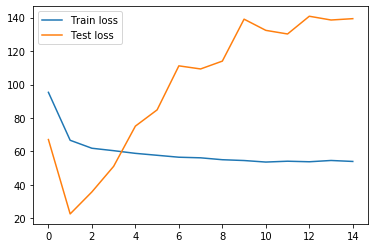

In [59]:

plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend();

In [37]:
preds = model.predict(test)

In [38]:
preds

array([[36.381706],
       [35.81288 ],
       [38.41641 ],
       ...,
       [33.302006],
       [33.088448],
       [33.088318]], dtype=float32)